<div style="float:left">
    <h1 style="width:600px">Workshop 7: Classification</h1>
    <h3 style="width:600px">CASA0006: Data Science for Spatial Systems</h3>
    <h3 style="width:600px">Author: Huanfa Chen</h3>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

This week we will focus on **classification algorithms and applications**.  Classifiers are highly useful in extracting patterns from large datasets. By setting up a classifier on an understood, pre-classified subset of the data, we are able to automatically derive greater understanding into other, unclassified datasets.

The process of creating a classifier remains the same no matter which method you use:

1. Organise and clean your dataset.
2. Divide the dataset into training and testing subsets.
3. Use the classifier to associate feature attributes within the training dataset to *known* classifications (known as *training* or *calibration*).
4. Test the strength of model fit by predicting the classifications within the test dataset (known as *testing* or *validation*).
5. If you are happy with the model performance, you can apply the classifier to any new and future data in order to establish classifications. This provides instant insight into the type of data you are receiving.

Once more during this session, we will use Python and specifically the **`pandas`** and **`scikit-learn`** libraries. The method for the application of different classification methods using `sklearn` is helpfully very consistent, as such we will explore a range of different methods today. We will also look at ways to explore the quality of the prediction results, in order to understand how well our mining is going.

As usual, we need to import the relevant libraries to get started, so **run the script below** first to give us access to our basic data analysis packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places

### Data Preprocessing

The dataset you'll be working with today relates to the personal characteristics of over 32,000 individuals. Our task is to work out whether we can predict whether an individual's income is above or below $50,000 per annum, based solely on their demographic characteristics. While we are dealing with quite a few attributes here, we're only predicting over two classes, thus it is a relatively straightforward classification problem.

**Download the dataset from Github, and import it as a Pandas dataframe called `original_data`. Inspect the dataset, and use the accompanying metadata to help you understand what you have.**

In [2]:
original_data=pd.read_csv('https://raw.githubusercontent.com/huanfachen/Spatial_Data_Science/main/Dataset/income.csv')

In [3]:
original_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,over50k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


As you will notice, the data you have been provided with an indicator stating whether the individual does or does not earn over $50000 per annum. Well we use this indicator to define the relationship between the individual's characteristics and this classification.

But to get their, we need to start splitting up our dataset. We need one dataset containing our attribute data, and we need one dataset containing our classifications. We'll eventually pass both of these to the classifier so that it can identify the classification relationship.

So first, we will create our attribute dataset. **Create a new dataframe called `data` that includes all attributes from `original_data` except the `over50k` attribute. Remember to check the contents of your new dataframe to ensure this is the case.**

In [4]:
len(original_data.columns)

15

In [5]:
data=original_data.iloc[:, :14]

Now we will create the label dataset (the `y` variable) by transforming the `over50k` variable into numerics. To do this, we'll use the `LabelEncoder`. This function takes a column of target labels and encode target labels with value between 0 and `n_classes - 1`. A documentation of this function is [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

We can later use the same encoder to reverse the encoding.

**Run the scripts below to first import the `LabelEncoder` tools, and then create the labels dataset from the `over50k` class column.** 

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
le = LabelEncoder() # creates the LabelEncoder object
le.fit(['<=50K', '>50K']) # we explicitly encode '<=50k' and '>50k' with 0 and 1, respectively
label_y = le.transform(original_data['over50k']) # runs LabelEncoder on the over50k column

Now the target variable is ready to go. Next, we need to preprocess the X variables and convert them to numericals, as the `sklearn` classification methods do not play well with text variables.

We do this by converting each categorical attribute into a range of additional boolean columns representing each category, marked with 1s or 0s. This does not change the structure of the dataset as the boolean values will continue to to distinguish between features.

In this case, we use `DictVectorizer`. `DictVectorizer` takes our data as a series of dictionaries, and transforms it into a matrix which is free of categorical data. This function is similar to the `pandas.get_dummies`, although some differences exist. For example, `DictVectorizer` can be integrated into a pipeline in `sklearn` which simplifies the model building, but `pandas.get_dummies` cannot be used with a `sklearn` pipeline.

**Run through the following commands.** Starting with importing the `DictVectorizer` function.

In [8]:
from sklearn.feature_extraction import DictVectorizer

Now we convert our attribute data to an array of dictionaries for the `DictVectorizer`. We use the `Pandas.to_dict()` function for this. The `'records'` flag ensures that the attribute dataset is converted into an array of dictionaries, where each dictionary represents a single data record.

**Run the script to create the dictionaries, and verify the data by checking the first entry.**

In [9]:
data_dict = data.to_dict('records')

**Now we run the `DictVectorizer` to extract the matrix.** This is a very simple procedure, and note below how the commands needed to run this are very similar to those used earlier.

In [10]:
vec = DictVectorizer()  # create the DictVectorizer object
vec_array = vec.fit_transform(data_dict).toarray()  # execute process on the record dictionaries and transform the result into a numpy array object

**Now check `vec_array` to see how widely the dataset has been expanded (remember it consisted of 14 attributes before).**

In [11]:
vec_array

array([[3.9000e+01, 2.1740e+03, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [5.0000e+01, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.8000e+01, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [5.8000e+01, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.2000e+01, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [5.2000e+01, 1.5024e+04, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

We can view the feature names by calling the `get_feature_names` function.

In [12]:
vec.get_feature_names()

['age',
 'capital-gain',
 'capital-loss',
 'education-num',
 'education=10th',
 'education=11th',
 'education=12th',
 'education=1st-4th',
 'education=5th-6th',
 'education=7th-8th',
 'education=9th',
 'education=Assoc-acdm',
 'education=Assoc-voc',
 'education=Bachelors',
 'education=Doctorate',
 'education=HS-grad',
 'education=Masters',
 'education=Preschool',
 'education=Prof-school',
 'education=Some-college',
 'fnlwgt',
 'hours-per-week',
 'marital-status=Divorced',
 'marital-status=Married-AF-spouse',
 'marital-status=Married-civ-spouse',
 'marital-status=Married-spouse-absent',
 'marital-status=Never-married',
 'marital-status=Separated',
 'marital-status=Widowed',
 'native-country=?',
 'native-country=Cambodia',
 'native-country=Canada',
 'native-country=China',
 'native-country=Columbia',
 'native-country=Cuba',
 'native-country=Dominican-Republic',
 'native-country=Ecuador',
 'native-country=El-Salvador',
 'native-country=England',
 'native-country=France',
 'native-country=

The final stage in data processing involves splitting the prepared dataset into training and testing subsets. The training data will be used to create the classifier. The testing data will then be used to test the accuracy of a the classification. 

**IMPORTANT**: Splitting the dataset up in this way is an important step. It tests how well the classifier performs against data it hasn't yet seen. This gives a good picture of how well the classifier may work in future. However, remember that we are drawing both training and testing data from the same sample, and so future datasets may not align with the same biases.

Once more, we have a useful tool is `scikit` to do this. The `train_test_split` method (surprisingly named) randomly splits our attribute and label data into training and testing subsets. Not only does this provide us with  formats to be loaded directly into our classifers, but the random split ensures a good mixing of the records. 

The process is quite straightforward. **We load in the `train_test_split` method and run it against our attribute and label arrays.**

Note: `train_test_split` will split the data according to a 75:25 split, roughly in line with convention. However, other proportions can be specified, check out the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) for details.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_d, test_d, train_lab, test_lab = train_test_split(vec_array, label_y)

**Check the lengths of the training and testing datasets.**

In [15]:
len(train_d),len(test_d),len(train_lab),len(test_lab)

(24420, 8141, 24420, 8141)

We are now ready to start creating our classifiers.

### k-Nearest Neighbour Classification

The first classifier will use is the *k*-Nearest Neighbour (*k*NN) classifier. This is a very simple method by which tested points are classified according to their proximity (in terms of attribute distance) to points that were seen during training. 

In this section, we will show you how to use the *k*NN classifer in `scikit`, as well as going into detail about how you can assess the quality of the classification as part of your validation.

**IMPORTANT**: Many of the `scikit` classification methods use a very similar syntax. We will show you how to use *k*NN, but you will have to work out how to use the others. On completion, we expect you to be able to say which of the four classifiers you will test performs best in predicting whether the individuals in our test dataset earn more or less than $50k per annum.

Across all `scikit` classifiers, a similar process and form of syntax is used. 

1. First, we load the library. 
2. Then, we create the classifier object, and specify any important parameters.
3. We run the `.fit()` method, sending the classifier our training dataset and accompanying labels.
4. We analyse the validate with the `.score()` method, sending the classifier our testing dataset and accompanying labels.

Let's work through this method for the *k*NN classifer.

**First, we import the relevant library from `scikit`.**

In [16]:
from sklearn.neighbors import KNeighborsClassifier

Now, we create the classifier object and give it a name (`knn` in our case), and run it. 

On creating the object, we specify any important parameters. To understand what parameters are needed requires understanding the method and the syntax. It is worth you reading the `scikit` documentation on *k*NN at this point, which will provide you details on how to execute the method. 

[This page](http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification) is a general description of the method. Whereas [this page](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) outlines all of the parameters and methods associated with the `KNeighborsClassifier` method. You'll need to check the documentation for any classifer you use.

As you will recall, an important element of the *k*NN approach is the specification of how many neighbours to consider when making the classification. You can see below how this parameter is defined.

You'll see from the script below that running this process is very similar to the creation of clusters and regression models last week. **Before you run the script, add in a script to time how long the `.fit()` takes to execute, you'll do the same with other classifiers by way of comparison.**

In [17]:
# add timing script
knn = KNeighborsClassifier(n_neighbors=60)  # creates the kNN classifier, setting it to check the 60 neighbouring points
knn.fit(train_d, train_lab)  # executes the classifier on the training dataset

KNeighborsClassifier(n_neighbors=60)

Now, finally, we test how well the classifier predicts the classes of our test dataset. For this stage, we send the test data and labels to the `.score()` function. This outputs a number representing the proportion of classes correctly guessed by the classifer. It requires you to pass it both the test data and test labels.

**Run the script below to see how well *kNN* performs in this case.**

In [18]:
knn.score(test_d, test_lab)

0.7877410637513819

Well done, you've created and tested a classifer. And the classifier seems to do pretty well. In any future event, given a load more data we'll be able to predict the salary class of an individual with an expected accuracy of 79%, right? Well, hold on there, we better do some further tests just to check how good this score actually is...

There are a number of other important ways to assess the quality of your classifier that you should be aware of.

First, you can have a look yourself at the actual results, and identify the records where predictions succeed and fail. You can do this by generating a set of predictions for each record, done using the `.predict()` method. Like `.score()`, this generates classes for a test dataset, but does take a set of labels. You will use this method in classifying any future unlabelled dataset you wish to classify.

**The predictions are recorded within an array using the script below.**

In [19]:
predictions = knn.predict(test_d)

In [20]:
predictions

array([0, 0, 1, ..., 0, 0, 0])

If you look at `predictions`, however, you'll find just 0s and 1s, as these relate to the outputs generated by `LabelEncoder` earlier. What we need to do is convert these back to the original label data. We do this using the `le.inverse_transform` command. We then convert this into a list, and eventually into a Dataframe for easier manipulation. 

**Look at the code below and execute it to produce an ordered list of predicted classifications for the `test_d` dataset.**

In [21]:
predicted = pd.DataFrame(list(le.inverse_transform(predictions)))

Now you have this dataset, we want to explore how the predictions vary with the data. We will firstly do this manually (as a practice), and then use the `sklearn.metrics` library to achieve this automatically.

A manual way to explore the predictions: **first, run the label decoder again on the test labels.**

In [22]:
predicted

,0
0,<=50K
1,<=50K
2,>50K
3,<=50K
4,<=50K
...,...
8136,<=50K
8137,<=50K
8138,<=50K
8139,<=50K


**Next join the predicted classifications to the actual labels (from the test data) to create a new dataframe.**

In [23]:
test_data=pd.DataFrame(list(le.inverse_transform(test_lab)))

In [24]:
test_data.rename(columns={0: 'over50k'}, inplace=True)

**Finally, create a new column in the joined dataframe indicating whether the two label values match (check out the `.apply()` function).** You may need to rename your columns in order to achieve this.

In [25]:
result=pd.concat([test_data,predicted],axis=1)
result.rename(columns={0: 'predicted'}, inplace=True)

In [26]:
result

,over50k,predicted
0,<=50K,<=50K
1,<=50K,<=50K
2,>50K,<=50K
3,<=50K,<=50K
4,<=50K,<=50K
...,...,...
8136,<=50K,<=50K
8137,<=50K,<=50K
8138,<=50K,<=50K
8139,<=50K,<=50K


In [26]:
# adding a column of 'match' that indicates whether the prediction is correct
result['match']=None

In [27]:
# match as True if the prediction is correct, otherwise as False
for i,data in result.iterrows():
    if data['over50k']==data['predicted']:
        data['match']=True
    else:
        False

In [28]:
# calculate the accuracy rate
print('The accuracy rate is: ')
len(result.loc[result.match==True])/len(result)

The accuracy rate is: 


0.7877410637513819

So we have reinvented the 'wheel' of calculating the accuracy, which is not an easy job. In practice, we can utilise the `sklearn.metrics` library to check the classification result. This toolkit provides a range of measures relating to the predictive power of your classifier. 

A nice and simple exploratory tool is a confusion matrix. This describes the the extents to which each class was correctly and incorrectly classified. It is generated using the `confusion_matrix()` method, which takes the correct and predicted results. These can then be nicely visualised using the `matplotlib` matrix plotting functions.

**First, calcuating the accuracy score using the `metrics.accuracy_score` function.**

In [29]:
from sklearn import metrics
print("Classifcation accuracy: ")
print(metrics.accuracy_score(test_lab, predictions))

Classifcation accuracy: 
0.7877410637513819


**Second, create the matrix and inspect it - what can you derive from this?**

In [30]:
confusion_matrix = metrics.confusion_matrix(test_lab, predictions)

**Now, create the confusion matrix. Does this seem clearer? Where is the majority of the error in the classification?** You can read more about the confusion matrix [here](http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix).

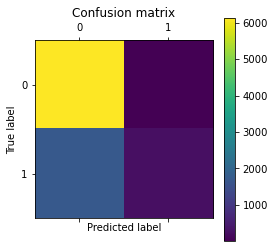

In [31]:
plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

While these measures above provide an overview of the classifier quality, other measures made available in the `metrics` toolset enable a more detailed understanding. Many of the most important measures can be extracted using the `classification_report()` method, which again takes correct labels and compares them against the classifier predictions.

These metrics, called `precision`, `recall` and `f1`, all measure how well a classifier does in predicting each class relative to how often it is incorrect. As such, it allows us to identify the prediction classes where it performs well and where it performs poorly.

**Before executing the code below, look at the [documentation](http://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules) here to gain a little understanding of these measures**

In [32]:
print("Classification results: ")
print(metrics.classification_report(test_lab, predictions))

Classification results: 
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      6152
           1       0.95      0.14      0.24      1989

    accuracy                           0.79      8141
   macro avg       0.87      0.57      0.56      8141
weighted avg       0.82      0.79      0.72      8141



The above result provides a lot of insights into the classification. For example:

1. How many indivudlas are correctly classified regardless of their actual class? (Hint: accuray, 79.5%) 
1. How many individuals with incomes over 50K are correctly recognised by the classifier? (Hint: recall, 14%)
1. Out of all individuals that are classified as earning over 50K, how many of them actually have an income higher than 50K? (Hint: precision, 92%)

The most striking of these results is that the classifier performs very poorly in identifying individuals earning over 50,000 per annum, which is indicated by the very low recall score. For class of `over50K`, the recall is 0.14, which means that only 14 out of 100 individuals earning over $50,000 are correctly recognised by the kNN classifier.

**This should be a concern to us**.

In the real world, you would consider two potential actions in response to findings like these:

1. Change the sample data by adding more individuals of `over50K`;
2. Recreate the classifier using a different set of hyperparameters (aka, hyperparameter tuning);
3. Use a different classifier to see if it leads to better results;

Next, we will try other classifiers to see whether we can get a higher classification accuracy or recall.

### Decision Tree

Another method that we will try is the Decision Tree. 

The Decision Tree does not (necessarily) require any parameters when being setup so is quite easy to implement, just follow the same method and syntax used above. In this case, however, you'll be working with  `DecisionTreeClassifier` rather than `KNeighborsClassifier`.

Before you start, check the [documentation](http://scikit-learn.org/stable/modules/tree.html#classification) here.

**Now create a Decision Tree classifier for the same scenario and datasets used earlier** (you don't need to recreate the datasets, they are good to go already). We've given you the library import code below to get you started.

In [33]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
tree = DecisionTreeClassifier()
tree.fit(train_d, train_lab)

DecisionTreeClassifier()

In [35]:
tree.score(test_d, test_lab)

0.8134135855546002

In [36]:
predictions = tree.predict(test_d)

In [37]:
predicted = pd.DataFrame(list(le.inverse_transform(predictions)))

In [38]:
confusion_matrix = metrics.confusion_matrix(test_lab, predictions)

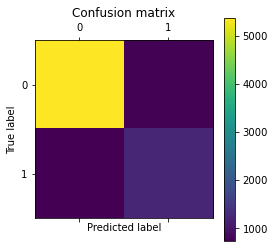

In [39]:
plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [41]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      6165
           1       0.61      0.62      0.62      1976

    accuracy                           0.81      8141
   macro avg       0.75      0.75      0.75      8141
weighted avg       0.81      0.81      0.81      8141



**Work through the stages used during the creation of the *k*-Nearest Neighbour classifier, and identify whether the Decision Tree outperforms this *k*NN approach or not.**

### Random Forest Classifer

Next, carry out the same process using a Random Forest classifier.

Unlike the Decision Tree, the Random Forest requires you to specify a parameter called `n_estimators`. This parameter specifies how many trees should be created in the construction of the whole forest. The more trees you choose, the longer the classification process will take to run.

So first, read up on the `scikit` Random Forest method [here](http://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees), and identify how you can set the `n_estimators` parameter and then follow through the same classifier creation and testing process used above.

**How well does this model perform relative to the Decision Tree and *k*-Nearest Neighbour approaches? How does varying the number of trees impact on the quality and speed of prediction?**

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
forest=RandomForestClassifier(n_estimators=10)

In [42]:
forest.fit(train_d,train_lab)

RandomForestClassifier(n_estimators=10)

In [43]:
## the score function can be used to make predictions on a new dataset and then to calculate the accuracy score.
forest.score(test_d, test_lab)

0.844490848790075

In [44]:
predictions = forest.predict(test_d)

In [45]:
confusion_matrix = metrics.confusion_matrix(test_lab, predictions)

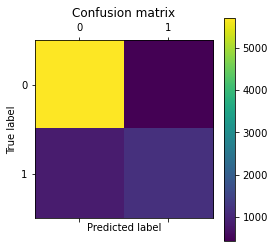

In [46]:
plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [47]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6152
           1       0.73      0.58      0.65      1989

    accuracy                           0.84      8141
   macro avg       0.80      0.76      0.77      8141
weighted avg       0.84      0.84      0.84      8141



#### Hyperparameter tuning for random forests

In machine learinng, hyperparameters are model settings that control the learning process (e.g. number of trees in a random forest). They should be distinguished from **parameters** that are automatically learnt in the model training process (e.g. splits in a tree of a random forest).

Hyperparameters need to be predefined before model training. Normally, the packages that we use provide default value for hyperparameters. For example, if we create a `RandomForestClassifier` without specifying n_estimator, the number of trees (aka `n_estimators`) is set as 100 by default. More details can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Some of you may ask how to find the optimal number of trees for a random forest. There is no perfect answer for this question. A rule of thumb is that the more trees, the smaller variance in the classification result and the higher computation cost (e.g. memory and time). 

Here, we are interested to test whether we can find a better value for the number of trees. We would like to test a range of values, namely 50, 100, 200, 300, 400. Again, choosing these values is kind of subjective.

We will use the grid search and 5-fold cross validation to tune this hyperparameter.

An illustration of k-fold cross validation is as follows:

![](https://github.com/huanfachen/Spatial_Data_Science/raw/main/Images/grid_search_cross_validation.png)

First, we look at how to do cross validation in `sklearn`. There are different ways to do this in `sklearn`, and one of these is calling the `cross_val_score` function, which evaluates a score using cross validation. The documentation is [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

Here we focus on the accuracy score. So, run the following code to use cross validation for a random forest classifier (with 10 trees).

In [48]:
# number of fold as 5
cv_fold=5

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

clf = RandomForestClassifier(n_estimators=10)

# call the cross_val_score function
scores = cross_val_score(clf, train_d, train_lab, cv=cv_fold)
# note that this is an array
print(scores) 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.83845209 0.8531941  0.85421785 0.84172809 0.84316134]
Accuracy: 0.85 (+/- 0.01)


The result contains a list of five accuracy scores, each of which is generated by training a classifier on four folds and testing the classifier on the other fold. Then, the avearge and standard deviation of the accuracy scores is calculated and printed.

Second, we use the 5-fold cross validation and grid search to tune the `n_estimators`. Grid search is an exhaustive search procedure over specified parameter values for an estimator. 

We will use the **GridSearchCV** function from the `sklearn` library. This function integrates the grid search and cross validation procedure. Its documentation is [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Run the following code to do GridSearchCV. This process may take several minutes.

In [49]:
from sklearn import model_selection

# values of n_estimators
parameters = {'n_estimators':[50, 100, 200, 300, 400]}
rf = RandomForestClassifier()

clf = model_selection.GridSearchCV(rf, parameters)

clf.fit(train_d, train_lab)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [50, 100, 200, 300, 400]})

In [50]:
# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'n_estimators': 300}
The best score is: 
0.8568796068796068


On my computer, it says that the best n_estimators value is **300**. The result indicates that the default `n_estimators` value (**100**) is not optimal. Note that this might be subject to randomisation, which means you could get a different result after you run the above code.

### In Conclusion...

In this workshop, we have practiced several algorithms for classification and different techniques for building a classification models (e.g. splitting training and testing data, cross validation, grid search, hyperparameter tuning). Please be aware that these techniques are not restricted to classification models. They are widely applicable for supervised learning tasks in machine learning, e.g. regression.

There are a few challenges that I want you to explore. Go on, give at least one of them a go.

- Try to compare the results of different classification algorithms using different metrics (e.g. accuracy, precision, recall, F1). Which algorithm is the best?
- Try to tune the **k** hyperparameter in kNN. Which k leads to the highest accuracy?
- Implement logistic regression and artificial neural network for this task. The functions are available in sklearn and their use is similar to kNN and random forest.